In [1]:
import pandas as pd
import os
import os
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt

class QF_NRA:
    count = 0
    index = 0
    def __init__(self, init=False, path='../../QF_NRA', data_path='result', execl='base.xlsx'):
        self.path = path
        self.data_path = data_path
        self.records = pd.read_excel(execl, header=[0], index_col = [0])
        if init:
            self.records = self.records.drop(index=self.records.index)
            self.get_info(path)

    def get_info(self, path):
        folder_list = os.listdir(path)
        for folder in folder_list:
            new_path = os.path.join(path, folder)
            if os.path.isdir(new_path):
                self.get_info(new_path)
            else:
                with open(new_path) as f:
                    vars = 0
                    assertions = 0
                    line = f.readline()
                    while line:
                        if line[:3] == '(de':
                            vars += 1
                        elif line[:3] == '(as':
                            assertions += 1
                        line = f.readline()
                    # print(count, "/", total,": ", filename, "+", vars, "+", assertions)
                    self.count += 1
                    new_path = new_path[6:].replace('temp/', '')
                    category = new_path.split('/')[1]
                    # self.records = self.records.concat({'filename': new_path, 'category':category, 'vars':vars, 'assertions':assertions}, ignore_index=True, verify_integrity=True)
                    self.records.loc[len(self.records.index)] = [new_path, category, vars, assertions, '0', '0']

    def arrange(self):
        file_list = os.listdir(self.data_path)
        for filename in tqdm(file_list, desc=self.data_path):
            with open(os.path.join(self.data_path, filename)) as f:
                try:
                    while f.readline():
                        result = f.readline()[:-1]
                        if result[:3] == 'run':
                            result = 'dump'
                        info = f.readline()
                        name = info.split(' : ')[0]
                        timeout = info.split(' : ')[1][:-4]
                        # print(timeout)
                        # print(name)
                        # print(len(self.records.loc[self.records['filename'] == name]))
                        self.records.loc[self.records['filename'] == name, ['result', 'timeout']] = [result, timeout]
                except:
                    print(filename, ' ', info)
        
    def save_to(self, filename):
        self.records.to_excel(filename)
    
    def show(self):
        folder_list = os.listdir(self.path)
        count = []
        solved = []
        dump = []
        timeout = []
        for folder in folder_list:
            count.append(len(self.records[self.records['category'] == folder]))
            solved.append(len(self.records[(self.records['category'] == folder) & (self.records['result'].str.contains('sat'))]))
            dump.append(len(self.records[(self.records['category'] == folder) & (self.records['result'] == ('dump'))]))
            timeout.append(len(self.records[(self.records['category'] == folder) & (self.records['result'] == ('timeout'))]))
        plt.figure(figsize=(18, 8))
        plt.bar(folder_list, solved, label="solved", color='green')
        plt.bar(folder_list, timeout, label="timeout", bottom=solved, color='orange')
        bot = [i + j for i, j in zip(solved, timeout)]
        plt.bar(folder_list, dump, label="dump", bottom=bot, color='red')
        # plt.bar(folder_list, count, label="total", bottom=timeout, color='gray')
        plt.legend(fontsize=11, frameon=False, loc='upper center')
        plt.xticks(rotation=270)
        plt.show()
    
    def get_timeout(self, source_path='../../QF_NRA_base', target_path='../../QF_NRA_timeout'):
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        if os.path.exists(target_path):
            shutil.rmtree(target_path)
        shutil.copytree(source_path, target_path)
        print('copy dir finished, begin delete!')
        self.delete(target_path)

    def delete(self, path):
        folder_list = os.listdir(path)
        for folder in folder_list:
            new_path = os.path.join(path, folder)
            if os.path.isdir(new_path):
                self.delete(new_path)
            else:
                name = new_path[6:].replace('temp/', '').replace('_timeout', '')
                if len(self.records[(self.records['filename'] == name) & (self.records['result'] == ('timeout'))]) == 0:
                    os.remove(new_path)
                    
    def get_number(self, path):
        index = 0
        folder_list = os.listdir(path)
        for folder in folder_list:
            new_path = os.path.join(path, folder)
            if os.path.isdir(new_path):
                index += self.get_number(new_path)
            else:
                index += 1
        return index

In [ ]:
a = QF_NRA(init=True)
a.records
a.save_to('base.xlsx')

In [2]:
a = QF_NRA(execl='base.xlsx')
a.arrange()
a.save_to('result.xlsx')

result: 100%|██████████| 132/132 [00:25<00:00,  5.13it/s]


In [2]:
a = QF_NRA(execl='result.xlsx')
# a.delete(path='../../QF_NRA_timeout')
# a.get_number('../../QF_NRA_timeout')

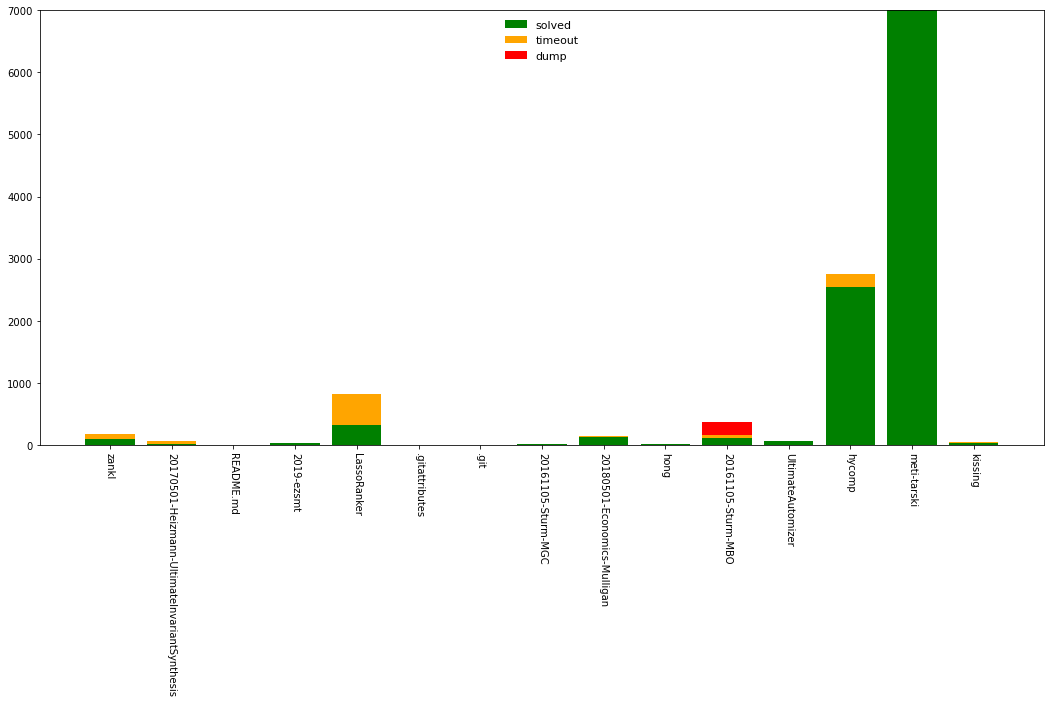

In [3]:
a.show()